In [1]:
import os, sys
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.metrics import classification_report

ROOT = Path.cwd().parent
sys.path.append(str(ROOT))

from src.utils import get_project_paths, set_seed
from src.data_prep import build_preprocessor, stratified_train_val_test_split
from src.models import (
    build_logistic_pipeline,
    build_rf_pipeline,
    build_xgb_pipeline,
    train_with_grid_search,
    evaluate_roc_auc,
)
from src.evaluation import (
    compute_classification_metrics,
    plot_roc_curve,
    plot_precision_recall_curve,
    plot_confusion_matrix,
    print_classification_report,
)

set_seed(42)
paths = get_project_paths(ROOT)

df = pd.read_parquet(paths.data_processed / "churn_with_segments.parquet")
df.head()


,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,...,OrderCount,DaySinceLastOrder,CashbackAmount,tenure_months,avg_orders_per_month,avg_order_value,clv_proxy,TenureBin,OrderCountBin,segment
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,...,1.0,5.0,159.93,4.0,0.25,159.93,159.93,0-6,0-5,0
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,...,1.0,0.0,120.90,NaN,NaN,120.90,120.90,NaN,0-5,0
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,...,1.0,3.0,120.28,NaN,NaN,120.28,120.28,NaN,0-5,0
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,...,1.0,3.0,134.07,0.0,1.00,134.07,134.07,0-6,0-5,0
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,...,1.0,3.0,129.60,0.0,1.00,129.60,129.60,0-6,0-5,0


In [ ]:
target_col = "Churn"

numeric_features = [
    "Tenure",
    "CityTier",
    "WarehouseToHome",
    "HourSpendOnApp",
    "NumberOfDeviceRegistered",
    "SatisfactionScore",
    "NumberOfAddress",
    "Complain",
    "OrderAmountHikeFromlastYear",
    "CouponUsed",
    "OrderCount",
    "DaySinceLastOrder",
    "CashbackAmount",
    "clv_proxy",
]

categorical_features = [
    "PreferredLoginDevice",
    "PreferredPaymentMode",
    "Gender",
    "PreferedOrderCat",
    "MaritalStatus",
]

feature_cols = numeric_features + categorical_features

df_model = df.dropna(subset=[target_col])  # safety
train_df, val_df, test_df = stratified_train_val_test_split(
    df_model,
    target_col=target_col,
    test_size=0.2,
    val_size=0.1,
    random_state=42,
)

X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_val = val_df[feature_cols]
y_val = val_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]


In [3]:
preprocessor = build_preprocessor(
    numeric_features=numeric_features,
    categorical_features=categorical_features,
)

logit_pipe = build_logistic_pipeline(preprocessor)

logit_param_grid = {
    "clf__C": [0.1, 1.0, 10.0],
}

logit_bundle = train_with_grid_search(
    pipeline=logit_pipe,
    X_train=X_train,
    y_train=y_train,
    param_grid=logit_param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
)

logit_bundle.best_params
y_val_proba = logit_bundle.pipeline.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_proba >= 0.5).astype(int)

metrics_val = compute_classification_metrics(
    y_true=y_val.values,
    y_pred=y_val_pred,
    y_proba=y_val_proba,
)
metrics_val


Fitting 5 folds for each of 3 candidates, totalling 15 fits


{'accuracy': 0.8152753108348135,
 'precision': 0.47096774193548385,
 'recall': 0.7684210526315789,
 'f1': 0.584,
 'roc_auc': 0.8859199280251913}

In [4]:
rf_pipe = build_rf_pipeline(preprocessor)
rf_param_grid = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 6, 10],
    "clf__min_samples_split": [2, 10],
}

rf_bundle = train_with_grid_search(
    pipeline=rf_pipe,
    X_train=X_train,
    y_train=y_train,
    param_grid=rf_param_grid,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
)
xgb_pipe = build_xgb_pipeline(preprocessor)
xgb_param_grid = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [3, 5],
    "clf__learning_rate": [0.05, 0.1],
}

xgb_bundle = train_with_grid_search(
    pipeline=xgb_pipe,
    X_train=X_train,
    y_train=y_train,
    param_grid=xgb_param_grid,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [5]:
def evaluate_bundle(bundle, X_tr, y_tr, X_val, y_val, name: str):
    y_tr_proba = bundle.pipeline.predict_proba(X_tr)[:, 1]
    y_tr_pred = (y_tr_proba >= 0.5).astype(int)
    tr_metrics = compute_classification_metrics(y_tr, y_tr_pred, y_tr_proba)

    y_val_proba = bundle.pipeline.predict_proba(X_val)[:, 1]
    y_val_pred = (y_val_proba >= 0.5).astype(int)
    val_metrics = compute_classification_metrics(y_val, y_val_pred, y_val_proba)

    print(f"=== {name} ===")
    print("Train:", tr_metrics)
    print("Val:  ", val_metrics)
    print()
    return tr_metrics, val_metrics

evaluate_bundle(logit_bundle, X_train, y_train, X_val, y_val, "Logistic")
evaluate_bundle(rf_bundle, X_train, y_train, X_val, y_val, "RandomForest")
evaluate_bundle(xgb_bundle, X_train, y_train, X_val, y_val, "XGBoost")


=== Logistic ===
Train: {'accuracy': 0.8162902816544024, 'precision': 0.47368421052631576, 'recall': 0.8280542986425339, 'f1': 0.6026344676180022, 'roc_auc': 0.8984978700730772}
Val:   {'accuracy': 0.8152753108348135, 'precision': 0.47096774193548385, 'recall': 0.7684210526315789, 'f1': 0.584, 'roc_auc': 0.8859199280251913}

=== RandomForest ===
Train: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'roc_auc': 1.0}
Val:   {'accuracy': 0.9520426287744227, 'precision': 0.9857142857142858, 'recall': 0.7263157894736842, 'f1': 0.8363636363636363, 'roc_auc': 0.9841205578047684}

=== XGBoost ===
Train: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'roc_auc': 0.9999999999999999}
Val:   {'accuracy': 0.955595026642984, 'precision': 0.9487179487179487, 'recall': 0.7789473684210526, 'f1': 0.8554913294797688, 'roc_auc': 0.9770355375618534}



({'accuracy': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0,
  'roc_auc': 0.9999999999999999},
 {'accuracy': 0.955595026642984,
  'precision': 0.9487179487179487,
  'recall': 0.7789473684210526,
  'f1': 0.8554913294797688,
  'roc_auc': 0.9770355375618534})

In [6]:
best_bundle = xgb_bundle  # or rf_bundle/logit_bundle

y_test_proba = best_bundle.pipeline.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= 0.5).astype(int)

test_metrics = compute_classification_metrics(
    y_true=y_test.values,
    y_pred=y_test_pred,
    y_proba=y_test_proba,
)
test_metrics


{'accuracy': 0.977797513321492,
 'precision': 0.9661016949152542,
 'recall': 0.9,
 'f1': 0.9318801089918256,
 'roc_auc': 0.9901259559154296}

In [12]:
from pathlib import Path
import joblib

project_root = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path.cwd().parent

models_dir = project_root / "models"
models_dir.mkdir(exist_ok=True)

model_path = models_dir / "best_churn_pipeline.joblib"
joblib.dump(best_bundle.pipeline, model_path)

print("Saved pipeline to:", model_path)


Saved pipeline to: /Users/arnavthakur/Documents/Data Science Projects/customer-analytics-churn-segmentation/models/best_churn_pipeline.joblib


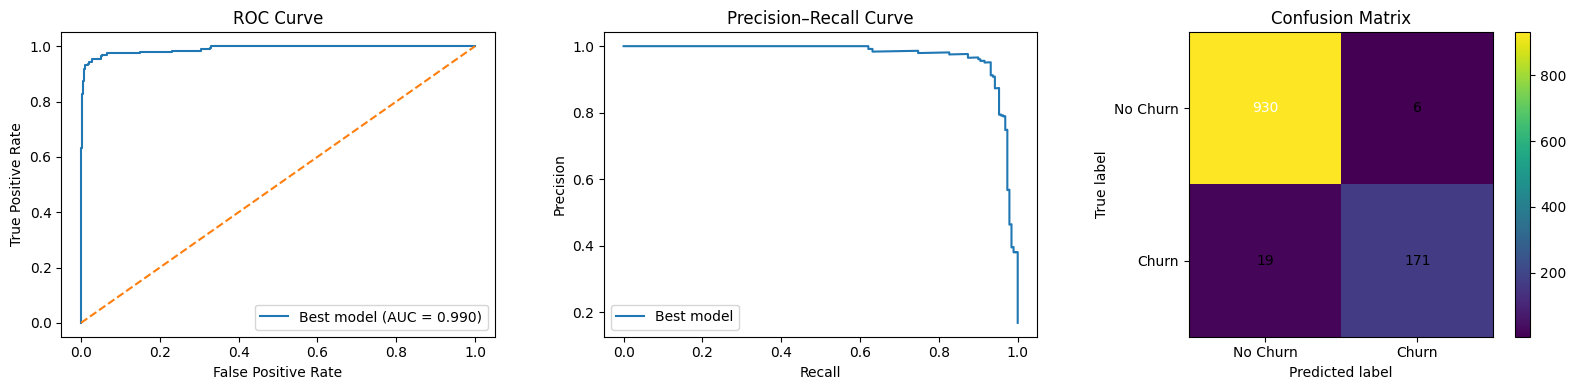

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(16, 4))

plot_roc_curve(y_test.values, y_test_proba, ax=ax[0], label="Best model")
plot_precision_recall_curve(y_test.values, y_test_proba, ax=ax[1], label="Best model")
plot_confusion_matrix(y_test.values, y_test_pred, ax=ax[2])

plt.tight_layout()
plt.show()


In [8]:
clf = best_bundle.pipeline.named_steps["clf"]

if hasattr(clf, "feature_importances_"):
    ohe = best_bundle.pipeline.named_steps["preprocess"].transformers_[1][1].named_steps["encoder"]
    ohe_feature_names = ohe.get_feature_names_out(categorical_features)

    feature_names = np.concatenate([numeric_features, ohe_feature_names])
    importances = clf.feature_importances_

    feat_imp = (
        pd.DataFrame({"feature": feature_names, "importance": importances})
        .sort_values("importance", ascending=False)
        .head(20)
    )
    feat_imp


In [9]:
test_with_seg = test_df.copy()
test_with_seg["y_true"] = y_test.values
test_with_seg["y_pred"] = y_test_pred
test_with_seg["y_proba"] = y_test_proba

segment_perf = (
    test_with_seg
    .groupby("segment")
    .apply(lambda g: compute_classification_metrics(g["y_true"], g["y_pred"], g["y_proba"]))
)

segment_perf


/var/folders/g9/h_z5g3c978x8bk1cf_7fv6tw0000gn/T/ipykernel_89995/969437454.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: compute_classification_metrics(g["y_true"], g["y_pred"], g["y_proba"]))


segment
0    {'accuracy': 0.9751098096632503, 'precision': ...
1    {'accuracy': 0.9952830188679245, 'precision': ...
2    {'accuracy': 0.9137931034482759, 'precision': ...
3    {'accuracy': 0.9884393063583815, 'precision': ...
dtype: object